# Noise Hamming weight and Pearson Correlation

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint
from guess_range import *
from batina_guess_number import *

## Visualize HW Behavior

In [2]:
def compute_corr(secret_hw, guess_range, known_inputs, guess_val_size=1000):
    low, high = guess_range
    guess_val = np.arange(low, high, (high - low) / (guess_val_size - 1e-127))
    hw = pd.DataFrame(columns=guess_val,
                        data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_val))
    return hw.corrwith(pd.Series(secret_hw), method='pearson')

In [3]:
guess_range=(0, 5e0)
# the number of guess values in the guess range
guess_val_size=1000
# generate the known inputs which is used to test the guess values
input_range = 2
known_inputs = np.random.uniform(-10 ** input_range, 10 ** input_range, 1000)

secret_number = np.random.uniform(guess_range[0], guess_range[1]) 
secret_number = 1.90826472023605
print('secret_number =', secret_number)

secret_number = 1.90826472023605


In [4]:
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
correlations = compute_corr(secret_hw, guess_range, known_inputs, guess_val_size)
correlations_1 = compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size*10))
correlations_2 = compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size/10))
correlations.sort_values(ascending=False).iloc[:10]

1.910    0.328501
3.815    0.324153
1.905    0.313453
1.915    0.278374
3.820    0.273737
0.955    0.261647
3.810    0.256723
1.920    0.251066
1.900    0.237075
3.830    0.222581
dtype: float64

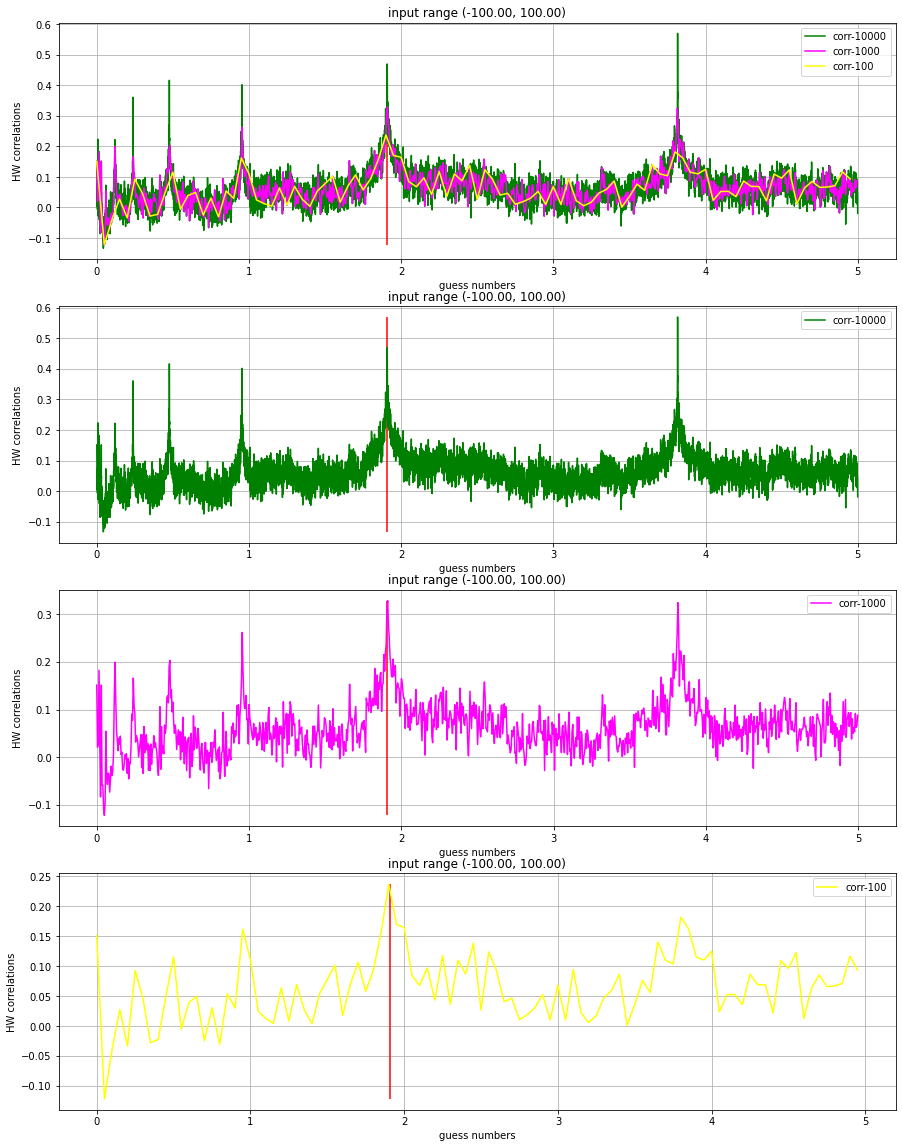

In [5]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 20))
correlations_1.plot(ax=ax[0], label='corr-%s' % correlations_1.shape[0], color='green')
correlations.plot(ax=ax[0], label='corr-%s' % correlations.shape[0], color='magenta')
correlations_2.plot(ax=ax[0], label='corr-%s' % correlations_2.shape[0], color='yellow')
ax[0].vlines(secret_number, correlations.min(), correlations.max(), color='red')

correlations_1.plot(ax=ax[1], label='corr-%s' % correlations_1.shape[0], color='green')
ax[1].vlines(secret_number, correlations_1.min(), correlations_1.max(), color='red')

correlations.plot(ax=ax[2], label='corr-%s' % correlations.shape[0], color='magenta')
ax[2].vlines(secret_number, correlations.min(), correlations.max(), color='red')

correlations_2.plot(ax=ax[3], label='corr-%s' % correlations_2.shape[0], color='yellow')
ax[3].vlines(secret_number, correlations_2.min(), correlations_2.max(), color='red')

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('guess numbers')
    a.set_ylabel('HW correlations')
    a.set_title('input range (%.02f, %.02f)' % (-10 ** input_range, 10 ** input_range))
    
plt.show()

## Correlation of mantissa

In [6]:
guess_numbers = build_guess_values(value_type='mantissa', mantissa_nbits=12, guess_range=guess_range)
mantisa_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

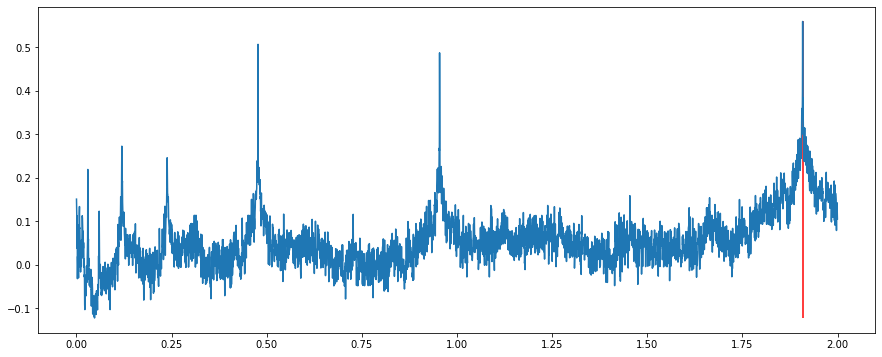

In [7]:
ax = mantisa_corr.sort_index().plot(figsize=(15,6))
ax.vlines(secret_number, mantisa_corr.min(), mantisa_corr.max(), color='red')

In [8]:
mantisa_corr.sort_values(ascending=False).iloc[:10]

1.908203    0.559388
0.477051    0.506844
0.954102    0.487296
1.907715    0.396565
1.909180    0.384324
1.908691    0.379883
1.906738    0.359708
1.909668    0.347587
1.905762    0.343444
1.907227    0.334916
dtype: float64

## Correlation exponent

In [9]:
guess_numbers = build_guess_values(value_type='exponent', numbers=mantisa_corr.sort_values(ascending=False).index[:10], guess_range=guess_range)
mantisa_exp_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

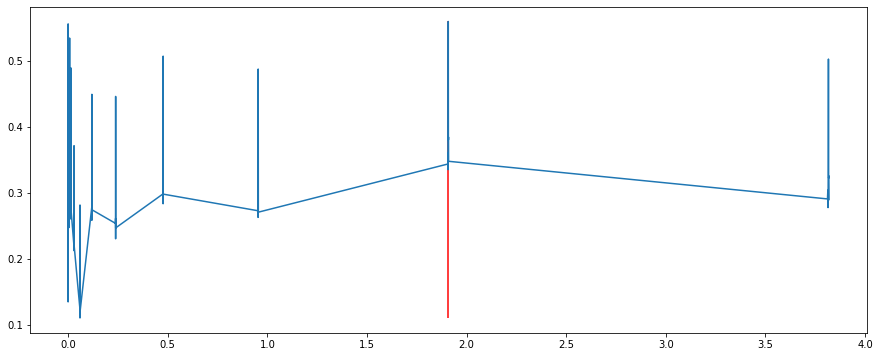

In [10]:
ax = mantisa_exp_corr.sort_index().plot(figsize=(15,6))
ax.vlines(secret_number, mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='red')

In [11]:
mantisa_exp_corr.sort_values(ascending=False).iloc[:10]

1.908203e+00    0.559388
1.908203e+00    0.559388
1.908203e+00    0.559388
1.034439e-19    0.555319
1.034439e-19    0.555319
1.034439e-19    0.555319
2.408491e-29    0.549774
4.442882e-10    0.549774
4.442882e-10    0.549774
4.442882e-10    0.549774
dtype: float64

## Correlation sign

In [12]:
guess_numbers = build_guess_values(value_type='sign', numbers=mantisa_exp_corr.sort_values(ascending=False).index[:10], guess_range=guess_range)
full_number_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

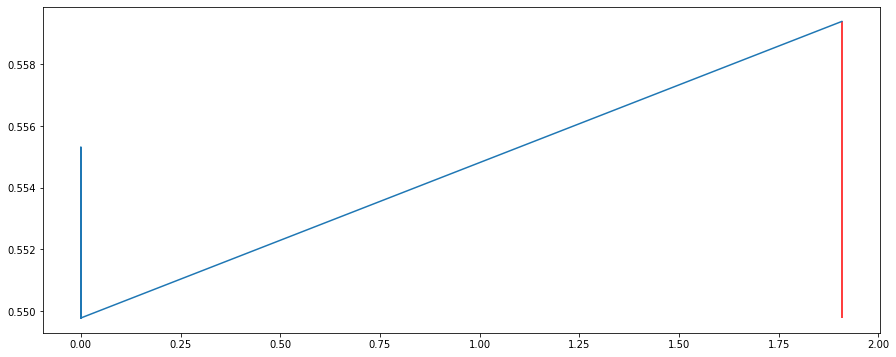

In [13]:
ax = full_number_corr.sort_index().plot(figsize=(15,6))
ax.vlines(secret_number, full_number_corr.min(), full_number_corr.max(), color='red')

In [14]:
full_number_corr.sort_values(ascending=False).iloc[:10]

1.908203e+00    0.559388
1.908203e+00    0.559388
1.908203e+00    0.559388
1.034439e-19    0.555319
1.034439e-19    0.555319
1.034439e-19    0.555319
4.442882e-10    0.549774
4.442882e-10    0.549774
4.442882e-10    0.549774
2.408491e-29    0.549774
dtype: float64

## Recover a secret number

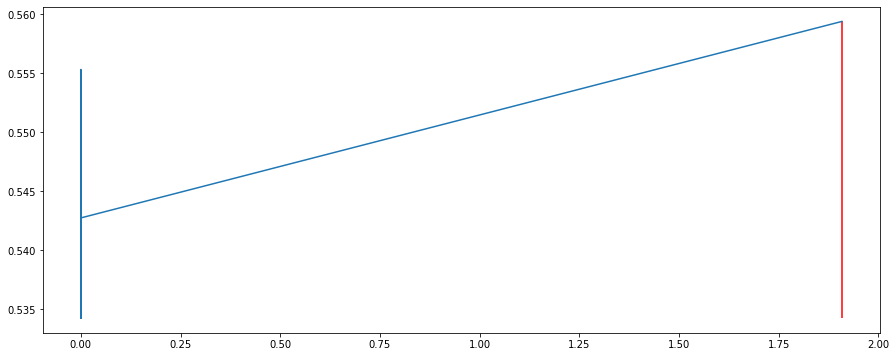

In [15]:
full_number_corr = batina_recover_weight(weight_hw=secret_hw, known_inputs=known_inputs, guess_range=guess_range)
ax = full_number_corr.sort_index().plot(figsize=(15,6))
ax.vlines(secret_number, full_number_corr.min(), full_number_corr.max(), color='red')

In [16]:
full_number_corr.sort_values(ascending=False).iloc[:10]

1.908203e+00    0.559388
1.034439e-19    0.555319
2.408491e-29    0.549774
4.442882e-10    0.549774
2.911687e-05    0.542748
1.578429e-24    0.542748
3.675066e-34    0.542748
6.779299e-15    0.542748
4.040777e-22    0.534271
1.435572e-36    0.534271
dtype: float64

## Analyze with noise - one number

In [17]:
def resize_known_inputs(known_inputs, new_len):
    """
    resize the known input to the new_len
    :param known_inputs: known inputs 
    :param new_len: new size of the know_inputs
    :return: the known
    """
    old_len = len(known_inputs)
    vf = np.vectorize(lambda i: known_inputs[int(i*old_len/new_len)])
    return vf(np.arange(0, new_len))

In [18]:
def add_noise_to_signal(signal, snr, freq):
    """
    add noise to the signal
    :param signal: signal
    :param snr: signal to noise ratio 
    :param freq: frequency of noise 
    :return: signal with noise
    """
    sig_max = signal.max()
    sig_min = signal.min()
    return pd.Series(signal).apply(lambda x: x  +
                                   np.average(np.random.normal(0.0, (sig_max-sig_min)/snr, freq)))

In [19]:
# the noise frequency is 50 times higher than HW signal frequency. Here we also increase
# the sizes of the computation with 
no_noise_secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)

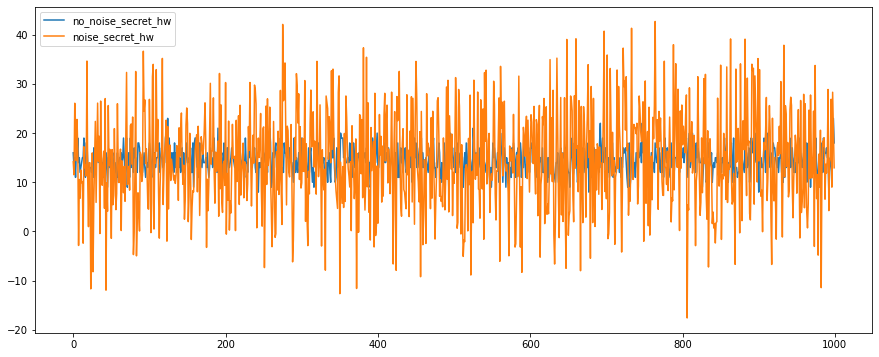

In [20]:
### Add noise to hamming weight of the multiplication of the secret number
signal_to_noise_ratio = 0.5
noise_secret_hw = add_noise_to_signal(signal=no_noise_secret_hw, snr=signal_to_noise_ratio, freq=10)
ax = pd.DataFrame([no_noise_secret_hw, noise_secret_hw], index=['no_noise_secret_hw', 'noise_secret_hw']).T.plot(figsize=(15,6))
ax.legend()

In [21]:
noise_correlations = compute_corr(noise_secret_hw, guess_range, known_inputs, guess_val_size)
print('secret_number =', secret_number)
noise_correlations.sort_values(ascending=False).iloc[:10]

secret_number = 1.90826472023605


3.285    0.099970
2.320    0.098872
1.905    0.094572
3.745    0.088987
4.640    0.088422
4.315    0.087416
1.160    0.083450
3.810    0.083305
4.585    0.082401
1.810    0.082374
dtype: float64

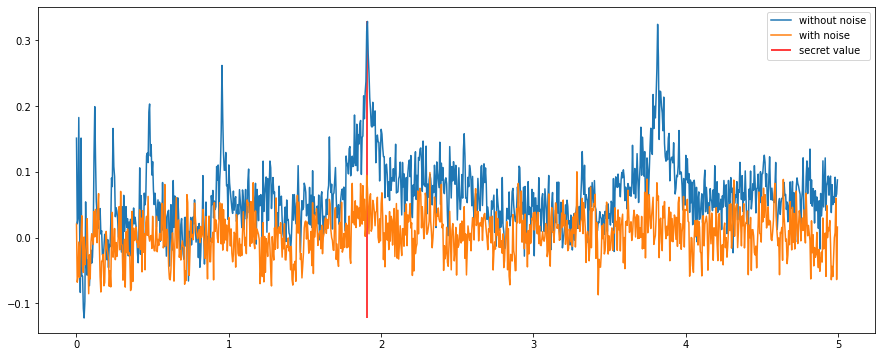

In [22]:
ax = correlations.plot(figsize=(15, 6), label='without noise')
noise_correlations.plot(ax=ax, label='with noise')
ax.vlines(secret_number, 
          min(noise_correlations.min(), correlations.min()),
          max(noise_correlations.max(), correlations.max()), 
          color='red', label='secret value')
ax.legend()

## Analyze with noise - multiple numbers

In [23]:
guess_range = (0.0, 5.0)
known_input_set = generate_known_inputs(exps=(-2,3), nsize=3000)
precision = 1e-6
n_secret_numbers = 10
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(n_secret_numbers*1/4))
))
np.random.shuffle(secret_numbers)
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

secret_numbers.shape = (9,)


In [24]:
secret_numbers_hws = {}
for idx in known_input_set.index:
    secret_numbers_hws[idx] = pd.DataFrame(
        columns=secret_numbers, 
        data=np.vectorize(hamming_weight)(np.asarray(known_input_set.loc[idx]).reshape(-1, 1) * secret_numbers))

In [25]:
secret_numbers_hws[0]

,3.438227,4.679594,0.795062,0.394012,0.412066,4.737823,0.986835,0.238603,1.127192
0,21,17,16,12,14,18,17,17,19
1,14,10,17,18,16,14,18,16,21
2,18,16,21,19,16,11,18,19,15
3,19,13,16,19,18,16,18,18,14
4,8,17,21,19,16,15,16,20,16
...,...,...,...,...,...,...,...,...,...
495,15,14,18,18,18,19,19,19,15
496,20,18,17,18,15,11,17,13,15
497,12,12,16,15,17,10,16,18,16
498,17,13,19,17,20,15,16,19,18


In [26]:
SECRET_VALUE='secret value'
df_index = [INPUT_ID, LOW_VALUE, HIGH_VALUE, CORRELATION, SECRET_VALUE]

In [27]:
%%time
# start guessing... - without noise first
results = pd.DataFrame()
for value in secret_numbers:
    for kidx in known_input_set.index:
        l, h, c = guess_number_range(secret_numbers_hws[kidx][value], guess_range, precision, known_input_set.loc[kidx])
        pprint('[%.06f] %02d %.06f %.06f %.06f' % (value, kidx, l, h, c))
        results = pd.concat([results, pd.Series([kidx, l, h, c, value], index=df_index)], axis=1, ignore_index=True)

'[3.438227] -2 3.438227 3.438227 0.999850'
'[3.438227] -1 3.438227 3.438227 0.999842'
'[3.438227] 00 3.438227 3.438227 1.000000'
'[3.438227] 01 3.438227 3.438227 0.999717'
'[3.438227] 02 3.438227 3.438227 1.000000'
'[3.438227] 03 3.438227 3.438227 0.999842'
'[4.679594] -2 4.679594 4.679595 0.999837'
'[4.679594] -1 4.679594 4.679595 0.999208'
'[4.679594] 00 4.679594 4.679595 1.000000'
'[4.679594] 01 4.679594 4.679595 0.999598'
'[4.679594] 02 4.679594 4.679595 0.999638'
'[4.679594] 03 4.679594 4.679595 0.999697'
'[0.795062] -2 0.003105 0.003106 0.914792'
'[0.795062] -1 3.180246 3.180246 0.970317'
'[0.795062] 00 0.795061 0.795062 0.999331'
'[0.795062] 01 0.795061 0.795062 0.997525'
'[0.795062] 02 0.795061 0.795062 0.999003'
'[0.795062] 03 0.795061 0.795062 0.998964'
'[0.394012] -2 0.394011 0.394012 0.999846'
'[0.394012] -1 0.394011 0.394012 0.998375'
'[0.394012] 00 0.394011 0.394012 0.999836'
'[0.394012] 01 0.394011 0.394012 0.999129'
'[0.394012] 02 0.394011 0.394012 0.999619'
'[0.394012]

In [28]:
### Add noise to hamming weight of the multiplication of the secret number
signal_to_noise_ratio = 0.5
noise_secret_numbers_hws = {}
for k in secret_numbers_hws.keys():
    noise_secret_numbers_hws[k] = secret_numbers_hws[k].apply(lambda hw: add_noise_to_signal(signal=hw, snr=signal_to_noise_ratio, freq=200), axis=0)
noise_secret_numbers_hws[0]    

,3.438227,4.679594,0.795062,0.394012,0.412066,4.737823,0.986835,0.238603,1.127192
0,19.449124,16.179685,15.388819,12.457262,15.609948,21.591354,19.380625,20.299864,16.987221
1,15.548532,9.308841,15.635731,23.565984,18.247120,13.258660,17.723760,18.861412,24.838269
2,25.372427,18.407577,18.942803,21.881718,16.808264,11.978529,17.755309,22.262048,11.928556
3,20.607872,12.173598,15.692329,19.666142,16.558376,15.379060,20.629029,19.379198,15.913867
4,8.832032,24.670902,23.848135,16.296539,15.315346,12.580808,13.272395,21.278705,16.699757
...,...,...,...,...,...,...,...,...,...
495,15.248543,12.493318,20.546497,16.948369,21.223273,19.880595,14.313474,18.304713,13.930694
496,16.454248,21.464408,19.669240,16.632930,13.551701,5.517730,17.066885,10.913680,15.469792
497,15.609484,9.330033,16.090428,14.164539,17.229547,14.787034,13.866341,20.954488,13.681620
498,20.848109,11.355905,16.646799,13.679268,22.433060,12.517217,18.297108,19.402594,18.489714


In [29]:
%%time
# start guessing... - with noise
noise_results = pd.DataFrame()
for value in secret_numbers:
    for kidx in known_input_set.index:
        l, h, c = guess_number_range(noise_secret_numbers_hws[kidx][value], guess_range, precision, known_input_set.loc[kidx])
        pprint('[%.06f] %02d %.06f %.06f %.06f' % (value, kidx, l, h, c))
        noise_results = pd.concat([noise_results, pd.Series([kidx, l, h, c, value], index=df_index)], axis=1, ignore_index=True)

'[3.438227] -2 3.438227 3.438227 0.750922'
'[3.438227] -1 3.437113 3.437113 0.411379'
'[3.438227] 00 3.438227 3.438227 0.815285'
'[3.438227] 01 3.438227 3.438227 0.752382'
'[3.438227] 02 3.437183 3.437183 0.360924'
'[3.438227] 03 3.438227 3.438227 0.767343'
'[4.679594] -2 4.679594 4.679595 0.698101'
'[4.679594] -1 4.679594 4.679595 0.679698'
'[4.679594] 00 4.679594 4.679595 0.839724'
'[4.679594] 01 4.679594 4.679595 0.729353'
'[4.679594] 02 4.679594 4.679595 0.770319'
'[4.679594] 03 4.679594 4.679595 0.784214'
'[0.795062] -2 0.795061 0.795062 0.781327'
'[0.795062] -1 0.003105 0.003106 0.678271'
'[0.795062] 00 0.795061 0.795062 0.795664'
'[0.795062] 01 0.795061 0.795062 0.795585'
'[0.795062] 02 0.795061 0.795062 0.776256'
'[0.795062] 03 0.795061 0.795062 0.818448'
'[0.394012] -2 0.788023 0.788023 0.780981'
'[0.394012] -1 0.394011 0.394012 0.794331'
'[0.394012] 00 0.394011 0.394012 0.703491'
'[0.394012] 01 0.394011 0.394012 0.816018'
'[0.394012] 02 0.394011 0.394012 0.778667'
'[0.394012]

In [30]:
%%time
# start guessing... - without noise
batina_results = pd.DataFrame(dtype=np.float32, columns=df_index)
for value in secret_numbers:
    for kidx in known_input_set.index:
        s = batina_recover_weight(weight_hw=secret_numbers_hws[kidx][value], guess_range=guess_range, known_inputs=known_input_set.loc[kidx])
        s.name = CORRELATION
        df = pd.DataFrame(s).reset_index().rename(columns={'index': LOW_VALUE})
        df[HIGH_VALUE] = df[LOW_VALUE]
        df[INPUT_ID] = kidx
        df[SECRET_VALUE] = value
        batina_results = pd.concat([batina_results, df], axis=0, ignore_index=True)

CPU times: user 55.4 s, sys: 512 ms, total: 55.9 s
Wall time: 55.9 s


In [31]:
%%time
# start guessing... - without noise
noise_batina_results = pd.DataFrame(dtype=np.float32, columns=df_index)
for value in secret_numbers:
    for kidx in known_input_set.index:
        s = batina_recover_weight(weight_hw=noise_secret_numbers_hws[kidx][value], guess_range=guess_range, known_inputs=known_input_set.loc[kidx])
        s.name = CORRELATION
        df = pd.DataFrame(s).reset_index().rename(columns={'index': LOW_VALUE})
        df[HIGH_VALUE] = df[LOW_VALUE]
        df[INPUT_ID] = kidx
        df[SECRET_VALUE] = value
        noise_batina_results = pd.concat([noise_batina_results, df], axis=0, ignore_index=True)

CPU times: user 55.6 s, sys: 428 ms, total: 56.1 s
Wall time: 56.1 s


### Statistics

In [32]:
GUESSED_VALUE = 'guessed value'
ERROR = 'error'
def statistics(df):
    dft = df.T
    dft[GUESSED_VALUE] = (dft[HIGH_VALUE]+dft[LOW_VALUE])/2.0
    dft[ERROR] = np.abs((dft[GUESSED_VALUE] - dft[SECRET_VALUE])/dft[SECRET_VALUE])
    best_corr = dft.loc[dft.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
    best_err = dft.loc[dft.groupby(SECRET_VALUE)[ERROR].idxmin()]
    return best_corr.T, best_err.T

In [33]:
best_corr, best_err = statistics(results)
noise_best_corr, noise_best_err = statistics(noise_results)

In [34]:
batina_best_corr, batina_best_err = statistics(batina_results.T)
noise_batina_best_corr, noise_batina_best_err = statistics(noise_batina_results.T)

In [35]:
noise_best_corr

,45,21,24,17,39,53,2,8,32
input id,1.000000e+00,1.000000e+00,-2.000000e+00,3.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
low value,2.386028e-01,3.940111e-01,4.120654e-01,7.950610e-01,9.868342e-01,1.127191e+00,3.438227e+00,4.679594e+00,4.737823e+00
high value,2.386034e-01,3.940117e-01,4.120660e-01,7.950616e-01,9.868348e-01,1.127192e+00,3.438227e+00,4.679595e+00,4.737824e+00
correlation,7.619126e-01,8.160183e-01,8.102460e-01,8.184477e-01,7.583356e-01,7.221598e-01,8.152851e-01,8.397236e-01,8.229366e-01
secret value,2.386028e-01,3.940116e-01,4.120656e-01,7.950615e-01,9.868346e-01,1.127192e+00,3.438227e+00,4.679594e+00,4.737823e+00
guessed value,2.386031e-01,3.940114e-01,4.120657e-01,7.950613e-01,9.868345e-01,1.127191e+00,3.438227e+00,4.679594e+00,4.737823e+00
error,9.724939e-07,3.098326e-07,2.473360e-07,3.091071e-07,1.231460e-07,1.363999e-07,6.369648e-08,4.186039e-08,3.286377e-08


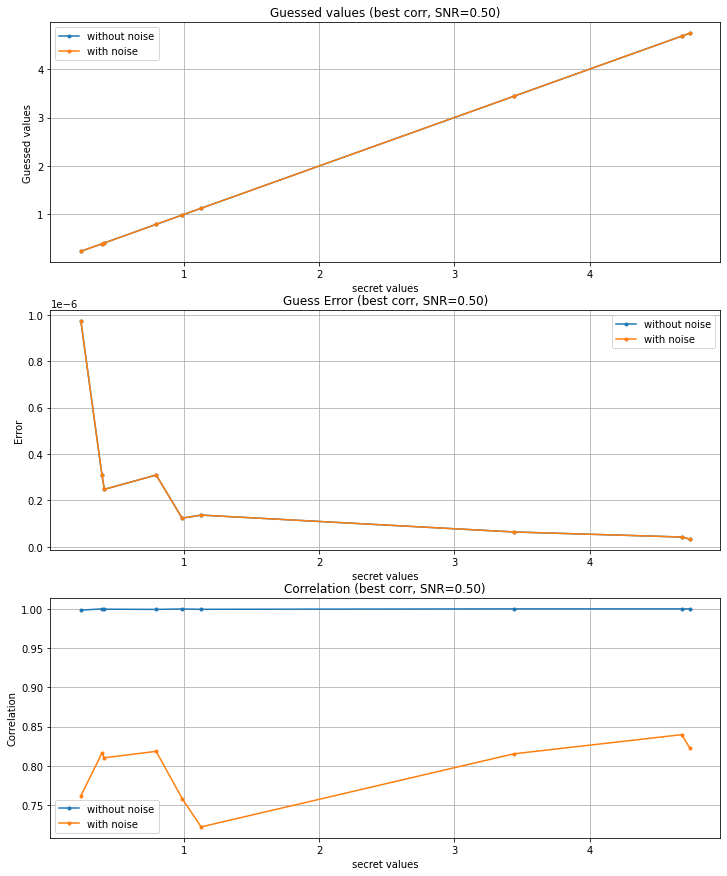

In [36]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()

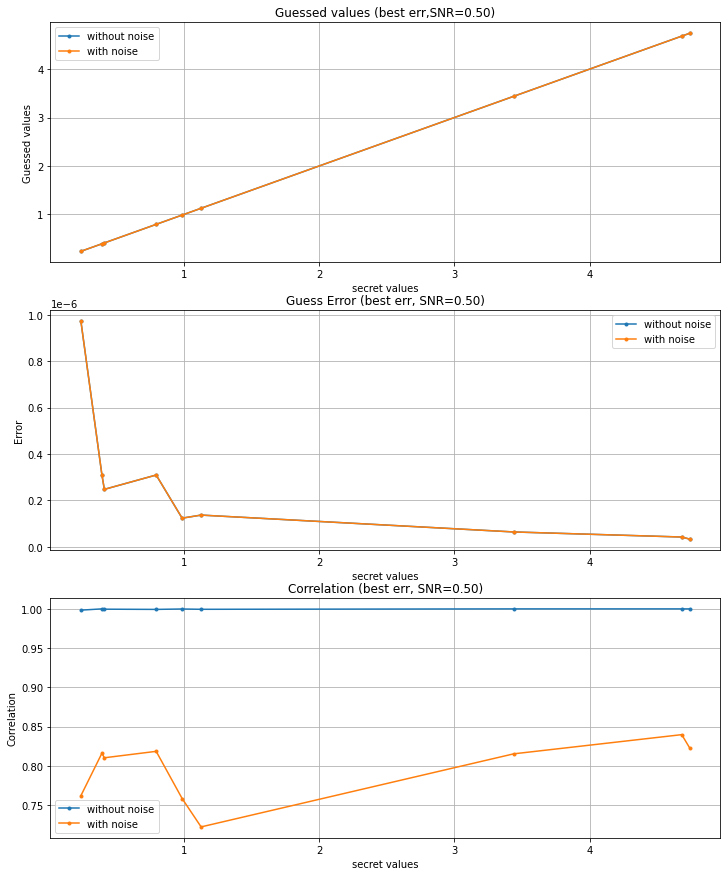

In [37]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = best_err.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_best_err.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (best err,SNR=%0.2f)' % signal_to_noise_ratio)


df = best_err.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_best_err.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (best err, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (best err, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()

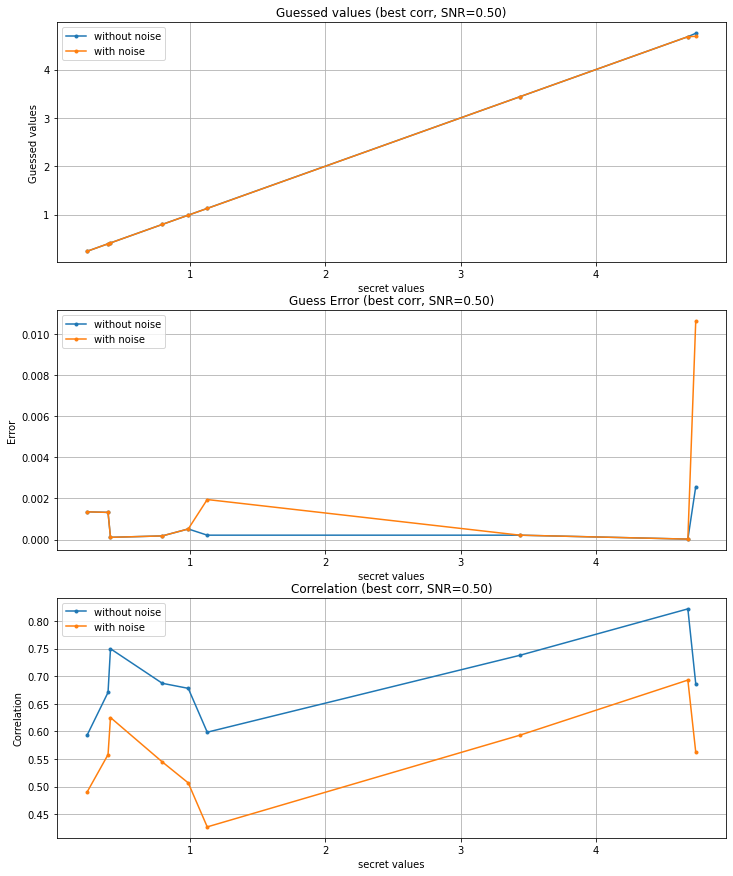

In [38]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = batina_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_batina_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = batina_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_batina_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = batina_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_batina_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()